In [3]:
import matplotlib.pyplot as plt
import scipy
import sympy
import numpy as np
import control 
import os
import array_to_latex as a2l
from ControlTheoryToolbox import System, CToolbox
import cvxpy

In [4]:
def get_K(system : System, alpha: float, mu :float = None, x0:np.array = None, precision : float = 0.01) -> tuple:
    
    P = cvxpy.Variable(system.A.shape)
    Y = cvxpy.Variable((system.B.T).shape)
    gamma = cvxpy.Variable()

    constraints = [P - precision*np.eye(system.A.shape[0]) >> 0, (P @ (system.A.T) + system.A @ P + 2 * alpha * P + (Y.T) @ (system.B.T) + system.B @ Y) + precision*np.eye(system.A.shape[0]) << 0]
    expr = cvxpy.sum_squares(P*0)
    if mu != None and not x0 is None:
        # constraint on output
        print(P.shape, Y.shape, np.ones(Y.shape[0], Y.shape[0]))
        constraints.append(cvxpy.bmat([[P, x0], [x0.T, np.ones(1).reshape(1, 1)]]) - precision*np.eye(system.A.shape[0] + 1) >> 0)
        constraints.append(cvxpy.bmat([[P, Y.T], [Y, mu*mu*np.ones(1).reshape(1, 1)]]) - precision*np.eye(system.A.shape[0] + Y.shape[0]) >> 0)
    elif mu == None and not x0 is None:
        
        constraints.append(cvxpy.bmat([[P, x0], [x0.T, np.ones(1).reshape(1, 1)]]) - precision*np.eye(system.A.shape[0] + 1) >> 0)
        constraints.append(cvxpy.bmat([[P, Y.T], [Y, gamma*np.ones(1).reshape(1, 1)]]) - precision*np.eye(system.A.shape[0] + Y.shape[0]) >> 0)
        expr = gamma
    problem = cvxpy.Problem(cvxpy.Minimize(expr), constraints)
    print("Time: ", problem.solve())
    P = P.value
    Y = Y.value
    # g = gamma.value
    # print(P, Y)
    K = Y@np.linalg.pinv(P)
    if mu == None and not x0 is None:
        print("mu: ", np.sqrt(gamma.value))
    assert np.all(num.real < -alpha for num in np.linalg.eig(system.A+system.B@K)[0])

    return K, P, Y

In [5]:
def task_1(system, desired_alpha, time_end = 3.0, **kwargs):
    time = np.linspace(0, time_end, 1000)
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    colors = ['blue', 'r', 'green']
    linestyle = ['-', '--', '-.']
    
    for j, alpha in enumerate(desired_alpha):
        K, P, Y = get_K(system, alpha, **kwargs)
        print(f"=============={alpha}==============")
        print("K: ")
        print(K)
        print("K latex: ")
        print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print("=============================")
        print("A + BK eigvalues: ")
        print(np.linalg.eig(system.A+system.B@K)[0])
        print("A + BK eigvalues latex: ")
        print(a2l.to_ltx(np.linalg.eig(system.A+system.B@K)[0], frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        
        ss = control.ss((system.A + system.B @ K), system.B*0, system.A * 0, system.B * 0)
        output = control.forced_response(ss, X0=[1, 1, 1, 1], T=time).states
        for i in range(system.A.shape[0]):
            idx = (i // 2, i % 2)
            if i == 0:
                linestyle = ['-', '--', '-.']
            else:
                linestyle = ['-', '-', '-']
            axs[idx].plot(time, output[i], linewidth=2, label=f"alpha = {alpha}", color=colors[-j], linestyle=linestyle[j])
            axs[idx].set_title(f'x_{i}(t)', fontsize=12)
            axs[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs[idx].grid(True)
            axs[idx].legend()

        # linestyle = ['-', '--', '-.']
        # axs_u.plot(time, (K @ output).reshape(-1), linewidth=2, label=f"alpha = {alpha}", color=colors[-j], linestyle=linestyle[j])
        # axs_u.set_title(f'u(t)', fontsize=12)
        # axs_u.set_xlabel(f"t, [c]", fontsize=12)
        # axs_u.grid(True)
        # axs_u.legend()
            

In [6]:
A = np.array([
    [-5, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 2, 6],
    [0, 0, -6, 2],
])
B = np.array([
    [0],
    [1],
    [0],
    [3]
])
print(a2l.to_ltx(A, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(B, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
system = System(A, B, A*0, B*0)

\begin{bmatrix}
 -5  &   0  &   0  &   0 \\
   0  &   0  &   0  &   0 \\
   0  &   0  &   2  &   6 \\
   0  &   0  & -6  &   2 
\end{bmatrix}
\begin{bmatrix}
   0 \\
   1 \\
   0 \\
   3 
\end{bmatrix}


Time:  0.0
==============1.0==============
K: 
[[ 0.         -1.98963054 -2.19842256 -2.02969124]]
K latex: 
\begin{bmatrix}
  0.00 & -1.99 & -2.20 & -2.03
\end{bmatrix}
A + BK eigvalues: 
[-1.3242631 +7.34121242j -1.3242631 -7.34121242j -1.43017805+0.j
 -5.        +0.j        ]
A + BK eigvalues latex: 
\begin{bmatrix}
 -1.32 + 7.34j & -1.32 + -7.34j & -1.43 + 0.00j & -5.00 + 0.00j
\end{bmatrix}
Time:  0.0
==============3.0==============
K: 
[[ 0.         -8.39990903 -7.04053475 -1.85593533]]
K latex: 
\begin{bmatrix}
  0.00 & -8.40 & -7.04 & -1.86
\end{bmatrix}
A + BK eigvalues: 
[-3.29995504+9.42748451j -3.29995504-9.42748451j -3.36780496+0.j
 -5.        +0.j        ]
A + BK eigvalues latex: 
\begin{bmatrix}
 -3.30 + 9.43j & -3.30 + -9.43j & -3.37 + 0.00j & -5.00 + 0.00j
\end{bmatrix}
Time:  0.0
==============10.0==============
K: 
[[   0.         -234.15890482  -88.66027717   64.87851388]]
K latex: 
\begin{bmatrix}
  0.00 & -234.16 & -88.66 &  64.88
\end{bmatrix}
A + BK eigvalues: 


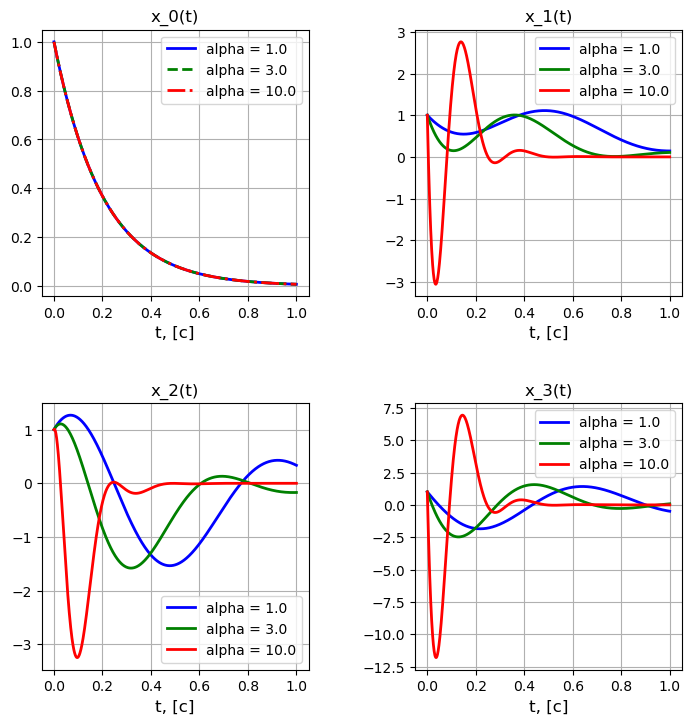

In [7]:
desired_alpha = [1.0, 3.0, 10.0]
task_1(system, desired_alpha, time_end=1.0)

In [8]:
def task_2(system, desired_mu, x0, time_end, **kwargs):
    time = np.linspace(0, time_end, 1000)
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    # fig2, axs_u = plt.subplots(1, 1, figsize=(4, 4))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)
    colors = ['blue', 'r', 'green']
    linestyle = ['-', '--', '-.']
    
    for j, mu in enumerate(desired_mu):
        K, P, Y = get_K(system, mu = mu, x0=x0, **kwargs)
        print(f"=============={mu}==============")
        print("K: ")
        print(K)
        print("K latex: ")
        print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print("=============================")
        print("A + BK eigvalues: ")
        print(np.linalg.eig(system.A+system.B@K)[0])
        print("A + BK eigvalues latex: ")
        print(a2l.to_ltx(np.linalg.eig(system.A+system.B@K)[0], frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        
        ss = control.ss((system.A + system.B @ K), system.B*0, system.A * 0, system.B * 0)
        output = control.forced_response(ss, X0=[1, 1, 1, 1], T=time).states
        for i in range(system.A.shape[0]):
            idx = (i // 2, i % 2)
            if i == 0:
                linestyle = ['-', '--', '-.']
            else:
                linestyle = ['-', '-', '-']
            axs[idx].plot(time, output[i], linewidth=2, label=f"mu = {mu}", color=colors[-j], linestyle=linestyle[j])
            axs[idx].set_title(f'x_{i}(t)', fontsize=12)
            axs[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs[idx].grid(True)
            axs[idx].legend()

        # linestyle = ['-', '-', '-']
        # axs_u.plot(time, (K @ output).reshape(-1), linewidth=2, label=f"mu = {mu}", color=colors[-j], linestyle=linestyle[j])
        # axs_u.set_title(f'u(t)', fontsize=12)
        # axs_u.set_xlabel(f"t, [c]", fontsize=12)
        # axs_u.grid(True)
        # axs_u.legend()

In [9]:
def task_2_2(system, desired_alpha, x0, time_end, **kwargs):
    time = np.linspace(0, time_end, 1000)
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig2, axs_u = plt.subplots(1, 1, figsize=(4, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)
    colors = ['blue', 'r', 'green']
    linestyle = ['-', '--', '-.']
    
    for j, alpha in enumerate(desired_alpha):
        K, P, Y = get_K(system, alpha = alpha, x0=x0, **kwargs)
        print(f"=============={alpha}==============")
        print("K: ")
        print(K)
        print("K latex: ")
        print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print("=============================")
        print("A + BK eigvalues: ")
        print(np.linalg.eig(system.A+system.B@K)[0])
        print("A + BK eigvalues latex: ")
        print(a2l.to_ltx(np.linalg.eig(system.A+system.B@K)[0], frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        
        ss = control.ss((system.A + system.B @ K), system.B*0, system.A * 0, system.B * 0)
        output = control.forced_response(ss, X0=[1, 1, 1, 1], T=time).states
        for i in range(system.A.shape[0]):
            idx = (i // 2, i % 2)
            if i == 0:
                linestyle = ['-', '--', '-.']
            else:
                linestyle = ['-', '-', '-']
            axs[idx].plot(time, output[i], linewidth=2, label=f"alpha = {alpha}", color=colors[-j], linestyle=linestyle[j])
            axs[idx].set_title(f'x_{i}(t)', fontsize=12)
            axs[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs[idx].grid(True)
            axs[idx].legend()

        linestyle = ['-', '-', '-']
        axs_u.plot(time, (K @ output).reshape(-1), linewidth=2, label=f"alpha = {alpha}", color=colors[-j], linestyle=linestyle[j])
        axs_u.set_title(f'u(t)', fontsize=12)
        axs_u.set_xlabel(f"t, [c]", fontsize=12)
        axs_u.grid(True)
        axs_u.legend()

(4, 4) (1, 4) [1]
Time:  0.0
==============7==============
K: 
[[ 0.29557497 -1.19501955 -1.32640675 -2.01915897]]
K latex: 
\begin{bmatrix}
  0.30 & -1.20 & -1.33 & -2.02
\end{bmatrix}
A + BK eigvalues: 
[-1.09089599+6.59197854j -1.09089599-6.59197854j -1.07070447+0.j
 -5.        +0.j        ]
A + BK eigvalues latex: 
\begin{bmatrix}
 -1.09 + 6.59j & -1.09 + -6.59j & -1.07 + 0.00j & -5.00 + 0.00j
\end{bmatrix}
(4, 4) (1, 4) [1]
Time:  0.0
==============12.0==============
K: 
[[ 5.55133101 -3.82323174 -5.18948149 -1.97557357]]
K latex: 
\begin{bmatrix}
  5.55 & -3.82 & -5.19 & -1.98
\end{bmatrix}
A + BK eigvalues: 
[-2.10880901+9.76495887j -2.10880901-9.76495887j -1.53233443+0.j
 -5.        +0.j        ]
A + BK eigvalues latex: 
\begin{bmatrix}
 -2.11 + 9.76j & -2.11 + -9.76j & -1.53 + 0.00j & -5.00 + 0.00j
\end{bmatrix}
(4, 4) (1, 4) [1]
Time:  0.0
==============20.0==============
K: 
[[ 16.68564396  -8.1887837  -10.73162223  -2.3709375 ]]
K latex: 
\begin{bmatrix}
  16.69 & -8.19 & -

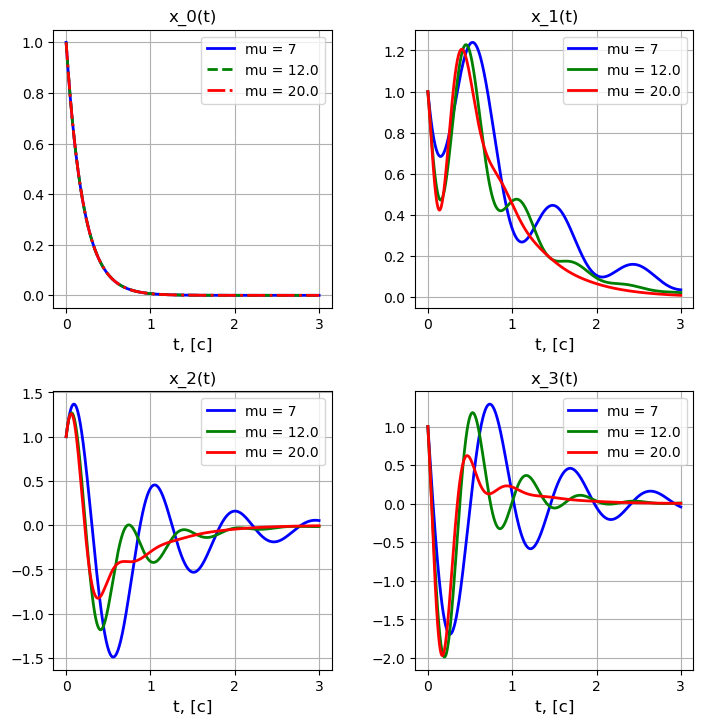

In [10]:
desired_mu = [7, 12.0, 20.0]
task_2(system, desired_mu=desired_mu, x0 = np.array([[1], [1], [1], [1]]),time_end=3.0, alpha=1.0)

Time:  37.54119898415397
mu:  6.127087316511327
==============1.0==============
K: 
[[ 2.85348010e-04 -1.09021091e+00 -1.20901607e+00 -1.97048621e+00]]
K latex: 
\begin{bmatrix}
  0.00 & -1.09 & -1.21 & -1.97
\end{bmatrix}
A + BK eigvalues: 
[-1.00046393+6.52496654j -1.00046393-6.52496654j -1.00074169+0.j
 -5.        +0.j        ]
A + BK eigvalues latex: 
\begin{bmatrix}
 -1.00 + 6.52j & -1.00 + -6.52j & -1.00 + 0.00j & -5.00 + 0.00j
\end{bmatrix}
Time:  422.3327267032943
mu:  20.550735429743003
==============3.0==============
K: 
[[ 3.08629655e-03 -5.40703130e+00 -4.82829895e+00 -2.53053190e+00]]
K latex: 
\begin{bmatrix}
  0.00 & -5.41 & -4.83 & -2.53
\end{bmatrix}
A + BK eigvalues: 
[-2.99951394+7.9439475j -2.99951394-7.9439475j -2.99959911+0.j
 -5.        +0.j       ]
A + BK eigvalues latex: 
\begin{bmatrix}
 -3.00 + 7.94j & -3.00 + -7.94j & -3.00 + 0.00j & -5.00 + 0.00j
\end{bmatrix}


/home/homa/anaconda3/envs/control/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Time:  143881.9044431966
mu:  379.3176827452111
==============10.0==============
K: 
[[ 572.37341798 -306.88573824 -116.96467436   71.96343421]]
K latex: 
\begin{bmatrix}
  572.37 & -306.89 & -116.96 &  71.96
\end{bmatrix}
A + BK eigvalues: 
[-70.27685343 +0.j          -8.35929109+10.23692793j
  -8.35929109-10.23692793j  -5.         +0.j        ]
A + BK eigvalues latex: 
\begin{bmatrix}
 -70.28 + 0.00j & -8.36 + 10.24j & -8.36 + -10.24j & -5.00 + 0.00j
\end{bmatrix}


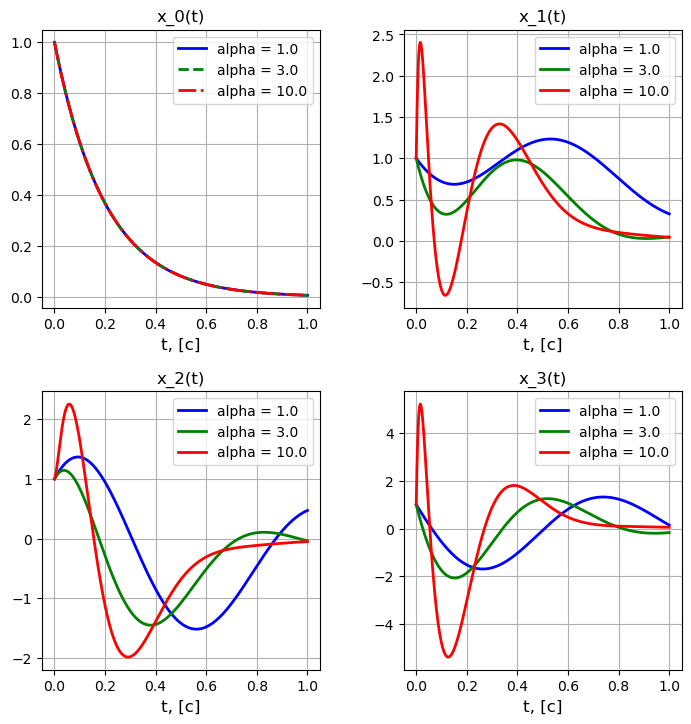

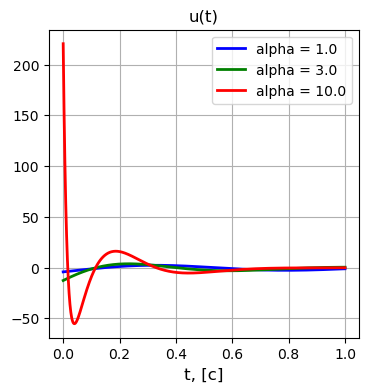

In [11]:
task_2_2(system, desired_alpha=desired_alpha, x0 = np.array([[1], [1], [1], [1]]),time_end=1.0)

In [16]:
def get_L(system : System, alpha: float, precision : float = 0.01) -> tuple:
    
    Q = cvxpy.Variable(system.A.shape)
    Y = cvxpy.Variable((system.C.T).shape)
    
    constraints = [Q - precision*np.eye(system.A.shape[0]) >> 0, system.A.T @ Q + Q @ system.A + 2*alpha*Q + system.C.T @ Y.T + Y @ system.C + precision*np.eye(system.A.shape[0]) << 0]
    expr = cvxpy.sum_squares(Q*0)
    
    problem = cvxpy.Problem(cvxpy.Minimize(expr), constraints)
    print("Result: ", problem.solve())
    Q = Q.value
    Y = Y.value
   
    L = np.linalg.pinv(Q) @ Y
    
    # assert np.all(num.real < -alpha for num in np.linalg.eig(system.A+system.B@K)[0])

    return L, Q, Y

In [47]:
def task_3(system, desired_alpha, time_end = 3.0, **kwargs):
    time = np.linspace(0, time_end, 1000)
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    fig2, axs_e = plt.subplots(2, 2, figsize=(8, 8))
    fig2.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    
    colors_system = ['blue', 'green']
    colors_observer = ['green', 'red', 'orange']
    linestyle = ['-', '--', '-.']
    
    for j, alpha in enumerate(desired_alpha):
        L, Q, Y = get_L(system, alpha, **kwargs)
        print(f"=============={alpha}==============")
        print("L: ")
        print(L)
        print("L latex: ")
        print(a2l.to_ltx(L, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print("=============================")
        print("A + LC eigvalues: ")
        print(np.linalg.eig(system.A+L@system.C)[0])
        print("A + LC eigvalues latex: ")
        print(a2l.to_ltx(np.linalg.eig(system.A+L@system.C)[0], frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        
        ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), system.C, np.zeros((system.C.shape[0], 1)))
        original_resp = control.forced_response(ss_orig, X0=[1, 1, 1, 1], T=time)
        ss = control.ss((system.A + L@system.C), -L, A*0, L*0)
        output = control.forced_response(ss, X0=[-1, -1, -1, -1], U=original_resp.outputs.reshape(-1), T=time).states
        for i in range(system.A.shape[0]):
            idx = (i // 2, i % 2)
            if i == 0:
                linestyle = ['-', '--', '-.']
            else:
                linestyle = ['-', '-', '-']
            if j == 0:
                axs[idx].plot(time, original_resp.states[i], linewidth=2, label=f"system", color='blue', linestyle='-')
            axs[idx].plot(time, output[i], linewidth=2, label=f"observer alpha = {alpha}", color=colors_observer[-j], linestyle='--')
            axs[idx].set_title(f'x_{i}(t)', fontsize=12)
            axs[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs[idx].grid(True)
            axs[idx].legend()

        # linestyle = ['-', '--', '-.']
            
            ss_e = control.ss(system.A+L@system.C, -L*0, system.C, np.zeros((system.C.shape[0], L.shape[1])))
            output_e = control.forced_response(ss_e, X0=[2, 2, 2, 2], T=time).states
            axs_e[idx].plot(time, output_e[i], linewidth=2, label=f"alpha = {alpha}", color=colors_observer[-j], linestyle='-')
            axs_e[idx].set_title(f'e_{i}(t)', fontsize=12)
            axs_e[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs_e[idx].grid(True)
            axs_e[idx].legend()
            

In [48]:
A = np.array([
    [0, 7, 0, 0],
    [-7, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, -2, 0],
])
C = np.array([
    [1, 0, 0, 6]
])
print(a2l.to_ltx(A, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(C, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
system = System(A, B*0, C, B*0)

\begin{bmatrix}
   0  &   7  &   0  &   0 \\
 -7  &   0  &   0  &   0 \\
   0  &   0  &   0  &   2 \\
   0  &   0  & -2  &   0 
\end{bmatrix}
\begin{bmatrix}
   1  &   0  &   0  &   6 
\end{bmatrix}


Result:  0.0
==============1.0==============
L: 
[[-1.69363694]
 [-2.36206043]
 [ 0.74555809]
 [-0.67115219]]
L latex: 
\begin{bmatrix}
 -1.69\\
 -2.36\\
  0.75\\
 -0.67
\end{bmatrix}
A + LC eigvalues: 
[-1.39767276+7.50544799j -1.39767276-7.50544799j -1.46260229+3.14320195j
 -1.46260229-3.14320195j]
A + LC eigvalues latex: 
\begin{bmatrix}
 -1.40 + 7.51j & -1.40 + -7.51j & -1.46 + 3.14j & -1.46 + -3.14j
\end{bmatrix}
Result:  0.0
==============3.0==============
L: 
[[  6.2059908 ]
 [-11.26762516]
 [  4.22526266]
 [ -3.15233567]]
L latex: 
\begin{bmatrix}
  6.21\\
 -11.27\\
  4.23\\
 -3.15
\end{bmatrix}
A + LC eigvalues: 
[-3.18581536+10.31183808j -3.18581536-10.31183808j
 -3.16819624 +3.96011155j -3.16819624 -3.96011155j]
A + LC eigvalues latex: 
\begin{bmatrix}
 -3.19 + 10.31j & -3.19 + -10.31j & -3.17 + 3.96j & -3.17 + -3.96j
\end{bmatrix}
Result:  0.0
==============5.0==============
L: 
[[170.13639205]
 [-25.518639  ]
 [ 52.11237875]
 [-32.51612152]]
L latex: 
\begin{bmatrix}
  170

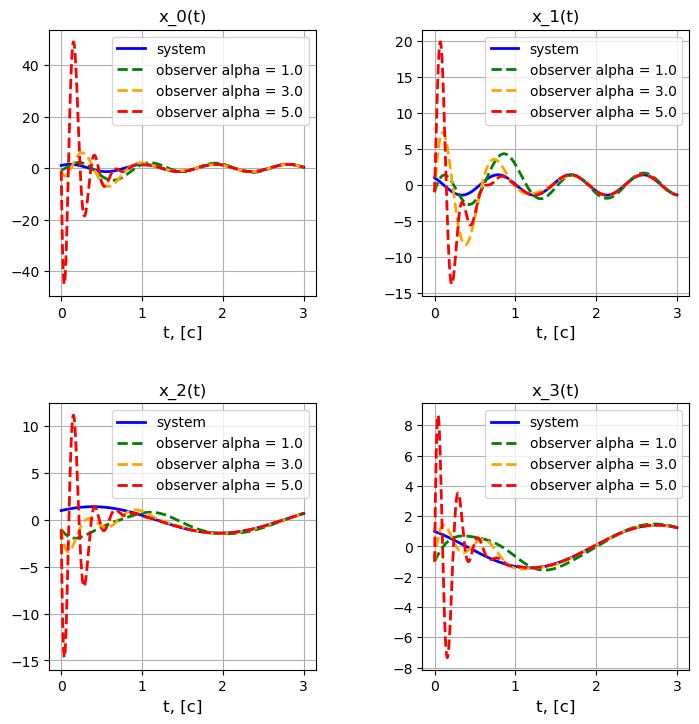

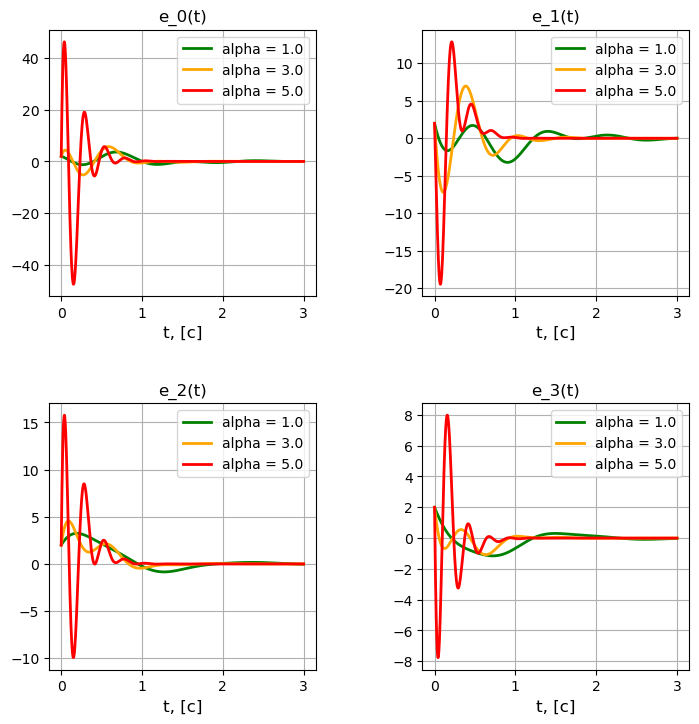

In [49]:
task_3(system, [1.0, 3.0, 5.0], time_end=3)

In [50]:
CToolbox.check_eigenvalues_observable(A, C)

array([ True,  True,  True,  True])

In [69]:
A = np.array([
    [3, -3, -5, 7],
    [-3, 3, -7, 5],
    [-5, -7, 3, 3],
    [7, 5, 3, 3],
])
B = np.array([
    [16],
    [12],
    [12],
    [12]
])
C = np.array([
    [3, -1, 1, 3],
    [-2, 2, 2, 2]
])
system = System(A, B, C, B*0)

In [98]:
def task_4(system, desired_alpha, time_end = 3.0, **kwargs):
    time = np.linspace(0, time_end, 1000)
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    fig2, axs_e = plt.subplots(2, 2, figsize=(8, 8))
    fig2.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    fig3, axs_u = plt.subplots(1, 1, figsize=(4, 4))
    fig3.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    fig4, axs_y = plt.subplots(1, 2, figsize=(8, 4))
    fig4.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    
    colors_system = ['blue', 'green']
    colors_observer = ['red', 'orange']
    linestyle = ['-', '--', '-.']
    
    for j, alpha in enumerate(desired_alpha):
        L, _, _ = get_L(system, alpha, **kwargs)
        K, _, _ = get_K(system, alpha, **kwargs)
        print(f"=============={alpha}==============")
        print("K: ")
        print(K)
        print("K latex: ")
        print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print("L: ")
        print(L)
        print("L latex: ")
        print(a2l.to_ltx(L, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print("=============================")
        print("A + BK eigvalues: ")
        print(np.linalg.eig(system.A+system.B@K)[0])
        print("A + BK eigvalues latex: ")
        print(a2l.to_ltx(np.linalg.eig(system.A+system.B@K)[0], frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        
        print("A + LC eigvalues: ")
        print(np.linalg.eig(system.A+L@system.C)[0])
        print("A + LC eigvalues latex: ")
        print(a2l.to_ltx(np.linalg.eig(system.A+L@system.C)[0], frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        
        new_A = np.block([[A, B @ K],[-L@C, A+B@K+L@C]])
        new_C = np.block([
            [C, np.zeros_like(C)],
            [np.zeros_like(C), C]
        ])
        x0 = np.array([
            [1],
            [1],
            [1],
            [1]
        ])
        xh0 = np.array([
            [-1],
            [-1],
            [-1],
            [-1]
        ])
        ss = control.ss(new_A, np.zeros((new_A.shape[0], 1)), new_C, np.zeros((new_C.shape[0], 1)))
        resp = control.forced_response(ss, X0=np.concatenate((x0, xh0), axis=0), T=time)
        for i in range(system.A.shape[0]):
            idx = (i // 2, i % 2)
            if i == 0:
                linestyle = ['-', '--', '-.']
            else:
                linestyle = ['-', '-', '-']
           
            axs[idx].plot(time, resp.states[i], linewidth=2, label=f"system alpha = {alpha}", color=colors_system[-j], linestyle='-')
            axs[idx].plot(time, resp.states[4+i], linewidth=2, label=f"observer alpha = {alpha}", color=colors_observer[-j], linestyle='--')
            axs[idx].set_title(f'x_{i}(t)', fontsize=12)
            axs[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs[idx].grid(True)
            axs[idx].legend()

        # linestyle = ['-', '--', '-.']
            
            ss_e = control.ss(system.A+L@system.C, -L*0, system.C, np.zeros((system.C.shape[0], L.shape[1])))
            output_e = control.forced_response(ss_e, X0=[2, 2, 2, 2], T=time).states
            axs_e[idx].plot(time, output_e[i], linewidth=2, label=f"alpha = {alpha}", color=colors_system[-j], linestyle='-')
            axs_e[idx].set_title(f'e_{i}(t)', fontsize=12)
            axs_e[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs_e[idx].grid(True)
            axs_e[idx].legend()


        for idx in range(2):
            axs_y[idx].plot(time, (C@resp.states[:4])[idx], linewidth=2, label=f"system alpha = {alpha}", color=colors_system[-j], linestyle='-')
            axs_y[idx].plot(time, (C@resp.states[4:])[idx], linewidth=2, label=f"observe alpha = {alpha}", color=colors_observer[-j], linestyle='--')
            axs_y[idx].set_title(f'y_{idx}(t)', fontsize=12)
            axs_y[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs_y[idx].grid(True)
            axs_y[idx].legend()
            # ss_e = control.ss(system.A+L@system.C, -L*0, system.C, np.zeros((system.C.shape[0], L.shape[1])))
            # output_e = control.forced_response(ss_e, X0=[2, 2, 2, 2], T=time).states
        axs_u.plot(time, (K@resp.states[4:]).reshape(-1), linewidth=2, label=f"alpha = {alpha}", color=colors_observer[-j], linestyle='-')
        axs_u.set_title(f'u(t)', fontsize=12)
        axs_u.set_xlabel(f"t, [c]", fontsize=12)
        axs_u.grid(True)
        axs_u.legend()
            

Result:  0.0
Time:  0.0
==============1.0==============
K: 
[[ 19.89583301 -79.25318811  58.01295308  -7.1988194 ]]
K latex: 
\begin{bmatrix}
  19.90 & -79.25 &  58.01 & -7.20
\end{bmatrix}
L: 
[[-13.22068176   0.68766774]
 [-28.41101927  -0.68736573]
 [ 28.41101921  -0.68736569]
 [-13.22068042  -0.68766776]]
L latex: 
\begin{bmatrix}
 -13.22 &  0.69\\
 -28.41 & -0.69\\
  28.41 & -0.69\\
 -13.22 & -0.69
\end{bmatrix}
A + BK eigvalues: 
[-3.34469913+55.5982572j -3.34469913-55.5982572j -2.1229634  +1.3609079j
 -2.1229634  -1.3609079j]
A + BK eigvalues latex: 
\begin{bmatrix}
 -3.34 + 55.60j & -3.34 + -55.60j & -2.12 + 1.36j & -2.12 + -1.36j
\end{bmatrix}
A + LC eigvalues: 
[ -1.25102402+12.54846465j  -1.25102402-12.54846465j
 -12.         +0.j          -1.50013383 +0.j        ]
A + LC eigvalues latex: 
\begin{bmatrix}
 -1.25 + 12.55j & -1.25 + -12.55j & -12.00 + 0.00j & -1.50 + 0.00j
\end{bmatrix}
Result:  0.0
Time:  0.0
==============4.0==============
K: 
[[ 17.09569843 -52.67280523  31

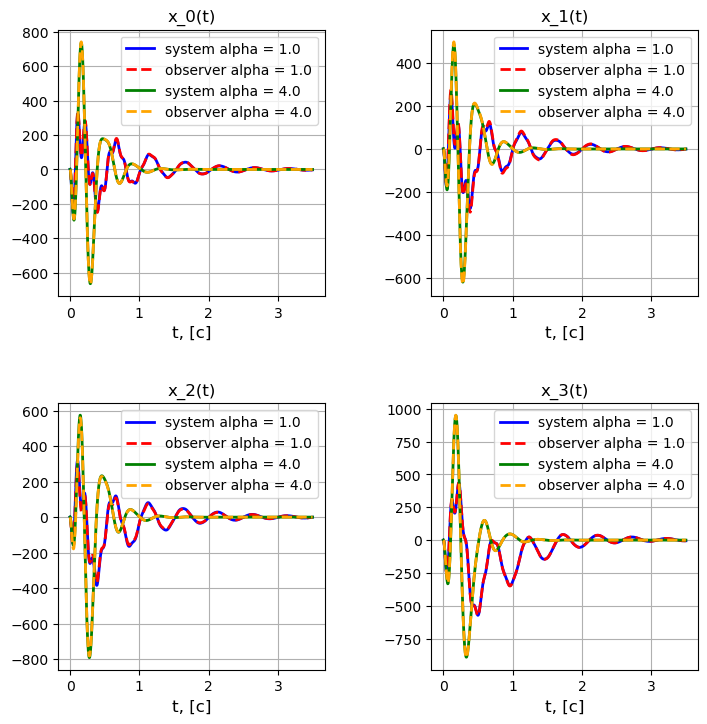

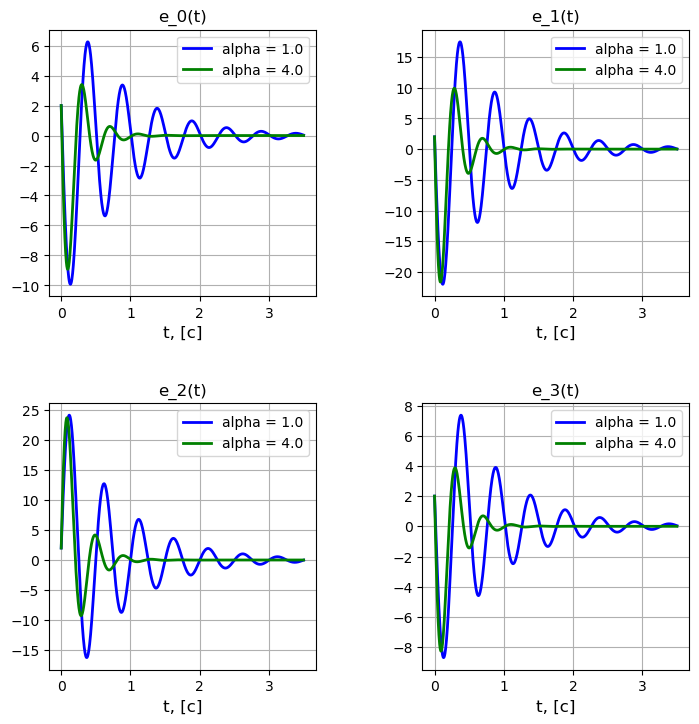

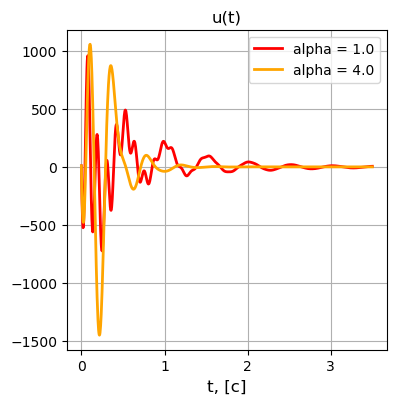

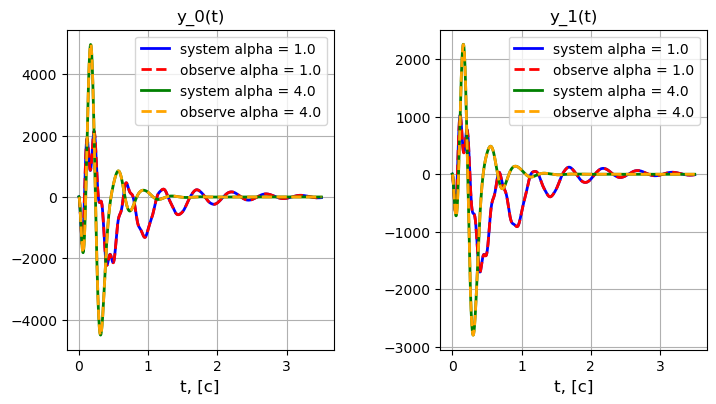

In [99]:
task_4(system, [1.0, 4.0], time_end=3.5)